### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.


### Program Configuration

In [1]:
# Select the API to use and load the benchmark program
api = "qiskit"
import hamlib_simulation_benchmark

# configure the QED-C Benchmark package for use with the given API
_, _ = hamlib_simulation_benchmark.qedc_benchmarks_init(api)

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 14
skip_qubits=1
max_circuits=1
num_shots=1000

# Select the backend 
#backend_id="qasm_simulator"
backend_id="statevector_simulator"
provider_backend=None
exec_options={}

#############

# place resulting data and images into a folder with "paper" suffix
import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"



In [2]:
import numpy as np
import time

# Configure module paths
import sys
sys.path.insert(1, "_common")
sys.path.insert(1, "qiskit")

sys.path.insert(1, "../_common/qiskit")
import execute

# Import HamLib helper functions (from _common)
import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
import hamlib_simulation_kernel

# Import Observable helper functions
import observables
import evolution_exact

verbose = True

#### for executing circuits to compute observables ...

# Import Qiskit and Qiskit Pauli operator classes
#from qiskit.quantum_info import Pauli, SparsePauliOp
#from qiskit import QuantumCircuit

# Initialize simulator backend
#from qiskit_aer import Aer
#backend = Aer.get_backend('qasm_simulator')

backend_id = "qasm_simulator"
exec_options = {}



# Custom optimization options can be specified in this cell (below is an example)

import sys
sys.path.insert(1, "../")

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model
exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })


execute.set_execution_target(backend_id, exec_options=exec_options)


### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [20]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[ 3 ]     # just do TFIM for now

###########

# list of observable computation methods to sweep
group_method_list = [ None, "simple", "N", "estimator" ]

# limit testing to simple for now
group_method = "simple"

print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# this could be a loop ...

print("============================================================\n")
print(f"Testing expectation grouping method: {group_method}\n") 



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}


Testing expectation grouping method: N



### Load the Given Hamiltonian to get its Pauli terms

In [4]:
# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
print(f"... dataset_name = {dataset_name}")
print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")

print("")

... dataset_name = bh_graph-1D-grid-nonpbc-qubitnodes_Lx-7_U-10_enc-gray_d-4
... sparse_pauli_terms = 
[({}, (70+0j)), ({0: 'X', 1: 'Z', 2: 'X'}, (-0.24999999999999994+0j)), ({0: 'X', 1: 'Z', 2: 'X', 3: 'Z'}, (0.06698729810778066+0j)), ({0: 'X', 1: 'Z', 2: 'Z', 3: 'X'}, (0.12940952255126037+0j)), ({0: 'X', 1: 'Z', 3: 'X'}, (-0.12940952255126037+0j)), ({0: 'X', 2: 'X'}, (0.9330127018922193+0j)), ({0: 'X', 2: 'X', 3: 'Z'}, (-0.24999999999999994+0j)), ({0: 'X', 2: 'Z', 3: 'X'}, (-0.48296291314453416+0j)), ({0: 'X', 3: 'X'}, (0.48296291314453416+0j)), ({0: 'Y', 1: 'Z', 2: 'Y'}, (-0.24999999999999994+0j)), ({0: 'Y', 1: 'Z', 2: 'Y', 3: 'Z'}, (0.9330127018922193+0j)), ({0: 'Y', 1: 'Z', 2: 'Z', 3: 'Y'}, (-0.48296291314453416+0j)), ({0: 'Y', 1: 'Z', 3: 'Y'}, (0.48296291314453416+0j)), ({0: 'Y', 2: 'Y'}, (0.06698729810778066+0j)), ({0: 'Y', 2: 'Y', 3: 'Z'}, (-0.24999999999999994+0j)), ({0: 'Y', 2: 'Z', 3: 'Y'}, (0.12940952255126037+0j)), ({0: 'Y', 3: 'Y'}, (-0.12940952255126037+0j)), ({0: 'Z'}, 

### Arrange Pauli Terms into Commuting Groups

In [5]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

print(f"... Number of groups created: {len(pauli_term_groups)}")
print(f"... Pauli Term Groups:")
for group in pauli_term_groups:
    print(group)
        


... finished grouping terms, total grouping time = 0.016 sec.

... Number of groups created: 10
... Pauli Term Groups:
[('IIIIIIIIIIIIII', (70+0j)), ('XZXIIIIIIIIIII', (-0.24999999999999994+0j)), ('XZXZIIIIIIIIII', (0.06698729810778066+0j)), ('XIXIIIIIIIIIII', (0.9330127018922193+0j)), ('XIXZIIIIIIIIII', (-0.24999999999999994+0j)), ('IZIIIIIIIIIIII', (-10+0j)), ('IIXZXIIIIIIIII', (-0.24999999999999994+0j)), ('IIXZXZIIIIIIII', (0.06698729810778066+0j)), ('IIXIXIIIIIIIII', (0.9330127018922193+0j)), ('IIXIXZIIIIIIII', (-0.24999999999999994+0j)), ('IIIZIIIIIIIIII', (-10+0j)), ('IIIIXZXIIIIIII', (-0.24999999999999994+0j)), ('IIIIXZXZIIIIII', (0.06698729810778066+0j)), ('IIIIXIXIIIIIII', (0.9330127018922193+0j)), ('IIIIXIXZIIIIII', (-0.24999999999999994+0j)), ('IIIIIZIIIIIIII', (-10+0j)), ('IIIIIIXZXIIIII', (-0.24999999999999994+0j)), ('IIIIIIXZXZIIII', (0.06698729810778066+0j)), ('IIIIIIXIXIIIII', (0.9330127018922193+0j)), ('IIIIIIXIXZIIII', (-0.24999999999999994+0j)), ('IIIIIIIZIIIIII', (

### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [6]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit

def get_ansatz(num_qubits, params):
    ansatz = EfficientSU2(num_qubits).decompose()
    ansatz.barrier()

    params_dict = {p: params[i] for i, p in enumerate(ansatz.parameters)}

    # Use assign_parameters instead of bind_parameters
    ansatz = ansatz.assign_parameters(params_dict)
    
    return ansatz

# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)
print(ansatz_circuit)


[ 0.307  1.352  0.646  0.282 -0.48   0.917 -0.392  2.462  2.913 -0.732
  1.833  0.182  0.428  2.674 -2.695 -2.594 -3.015  2.09   1.748  2.325
  3.007  1.88  -0.242  1.763 -2.398  0.879 -2.241  2.794  0.137 -0.536
 -1.479  1.723 -0.276  0.43  -3.024  0.739  0.704  0.735  2.788  1.142
 -0.883 -0.396  1.242 -2.763  1.048  1.072 -1.82  -2.332 -1.16  -0.856
  0.441 -0.386  3.069 -2.5   -1.829 -2.128  0.962 -1.55  -0.212 -1.606
 -2.143 -2.448  0.982 -2.273 -1.906 -0.825  2.017 -2.531  2.123 -2.538
  2.994 -0.197  2.996  0.659  1.503 -2.895 -1.365 -2.386 -1.281 -2.396
 -1.144 -0.539 -2.739  1.209  0.418 -1.474  0.146 -2.551  0.477  2.697
 -1.14   1.052 -2.313  1.359 -1.323 -1.991  0.544 -3.015  2.067 -3.112
  1.117 -1.445  1.478  2.904 -1.579  0.479  0.578  0.454 -1.74   2.845
 -0.332  2.177]
       ┌────────────┐ ┌─────────────┐                                      »
 q_0: ─┤ Ry(0.3067) ├─┤ Rz(-2.6953) ├──────────────────────────────────────»
       ├────────────┤ ├─────────────┤            

### Create Measurement Circuits from Base Circuit and Pauli Terms
Here, we append basis rotation gates for each Pauli Term group to the base evolution circuit to create an array of circuits for execution.

In [7]:
# generate an array of circuits, one for each pauli_string in list
def create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list):
    ts = time.time()
    
    circuits = hamlib_simulation_kernel.create_circuits_for_pauli_terms(qc, num_qubits, pauli_str_list)
    """
    print(f"... Appended {len(circuits)} circuits, one for each group:")               
    for circuit, group in list(zip(circuits, pauli_term_groups)):
        print(group)
        #print(circuit)
    """
    append_time = round(time.time()-ts, 3)
    ###print(f"\n... finished appending {len(circuits)} measurement circuits, total creating time = {append_time} sec.\n")

    return circuits


In [8]:
def do_execute(circuits, num_shots):
    
    # Initialize simulator backend
    from qiskit_aer import Aer
    #####backend = Aer.get_backend('qasm_simulator')
    #backend = Aer.get_backend('statevector_simulator')     # doesn't work, only returns 1 shot
    
    ### print(f"... begin executing {len(circuits)} circuits ...")
    ts = time.time()
    
    # Execute all of the circuits to obtain array of result objects
    ###### results = backend.run(circuits, num_shots=num_shots, noise_model=execute.noise).result()

    results = hamlib_simulation_benchmark.execute_circuits(
                                    backend_id = backend_id,
                                    circuits = circuits,
                                    num_shots = int(num_shots / len(circuits))
                                    )

    #for ca in results.get_counts():
    #    print(ca)
    
    exec_time = round(time.time()-ts, 3)
    ###print(f"... finished executing {len(circuits)} circuits, total execution time = {exec_time} sec.\n")

    return results


In [9]:
# Compute the total energy for the Hamiltonian
def compute_energy(num_qubits, results, pauli_term_groups):

    ###print(f"... begin computing observable value ...")
    ts = time.time()
    
    total_energy, term_contributions = observables.calculate_expectation_from_measurements(
                                                num_qubits, results, pauli_term_groups)
    obs_time = round(time.time()-ts, 3)
    ###print(f"... finished computing observable value, computation time = {obs_time} sec.\n")
    
    #print(f"    Total Energy: {round(np.real(total_energy), 4)}")
    ### print(f"    Term Contributions: {term_contributions}\n")

    create_time = 0
    group_time = 0
    append_time = 0
    exec_time = 0
    
    total_time = group_time + create_time + append_time + exec_time + obs_time
    total_time = round(total_time, 3)
    ###print(f"\n... total observable computation time = {total_time} sec.\n")
    
    return total_energy


In [10]:
# Compute exact value
def compute_exact_value(num_qubits, init_state, sparse_pauli_terms):
    
    #print(f"... begin classical computation of expectation value ...")                 
    ts = time.time()
    
    if num_qubits <= 20:
        correct_exp, correct_dist = evolution_exact.compute_expectation_exact(
                init_state,
                observables.ensure_pauli_terms(sparse_pauli_terms, num_qubits),
                0.0            # time
                )
    else:
        correct_exp = 0.001
        correct_dist = None
        
    exact_time = round(time.time()-ts, 3)
    """
    print(f"... exact computation time = {exact_time} sec")
    
    print(f"\nExact expectation value, computed classically: {round(np.real(correct_exp), 4)}")
    print(f"Estimated expectation value, computed using quantum algorithm: {round(np.real(total_energy), 4)}\n")
    """
    #simulation_quality = round(np.real(total_energy) / np.real(correct_exp), 3)
    #print(f"    ==> Simulation Quality: {np.real(simulation_quality)}\n")

    return correct_exp 


In [11]:
import random

def generate_random_int_and_bitstring(N):
    """
    Generates a random bitstring representing an integer from 0 to N-1,
    where N is a power of 2.

    Args:
        N (int): The upper bound (exclusive), must be a power of 2.

    Returns:
        str: A random bitstring representation of an integer in range [0, N-1].
    """
    if N <= 0 or (N & (N - 1)) != 0:
        raise ValueError("N must be a power of 2.")

    num_bits = N.bit_length() - 1  # Determine the number of bits needed
    random_number = random.randint(0, N - 1)  # Pick a random number in range [0, N-1]
    
    return random_number, format(random_number, f'0{num_bits}b')  # Convert to bitstring with leading zeros


### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


In [16]:
# Number of iterations performed with randome initialization
iterations = 500
count = 0

tracker_style = 1     # controls style of output printed each iteration - 1 - dots, 2 - detailed

print(f"... executing on num_qubits = {num_qubits}")
N = 2 ** num_qubits

# create arrays to hold metrics
init_values = []
exact_energies = []
computed_energies = []

# For each iteration, generate random input, compute observable, and store data
for it in range(iterations):
    global count
    count += 1

    #print(f"... doing iteration {it}")

    """
    # Create a quantum ansatz circuit with the given parameters (update later to use Parameter)
    qc = get_ansatz(num_qubits, params)  
    #print(qc)
    """
    init_value, init_state = generate_random_int_and_bitstring(N)
    #print(init_state)
    init_values.append(init_value)

    exact_energy = compute_exact_value(num_qubits, init_state, sparse_pauli_terms)
    exact_energies.append(exact_energy)
    
    # create Trotterized evolution circuit for HamLib Hamiltonian
    ts = time.time()
    qc, _ = hamlib_simulation_kernel.HamiltonianSimulation(
        num_qubits=num_qubits, 
        #ham_op=sparse_pauli_terms,
        K = 0, t = 0.0,
        init_state = init_state,
        append_measurements = False,
        method = 1, 
    )

    create_time = round(time.time()-ts, 3)
    #print(f"\n... finished creating base circuit, total creation time = {create_time} sec.\n")

    #print(qc)
    
    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list)


    #for c in circuits:
    #    print(c)

    
    results = do_execute(circuits, num_shots)

    energy = compute_energy(num_qubits, results, pauli_term_groups)
    energy = np.real(energy)

    computed_energies.append(energy)
    
    # print important data at each iteration (the cost and the associated parameter values)
    if tracker_style > 1:
        print(f"  {count:3} \t{energy: <7.5}  \t{[round(params[i], 4) for i in range(len(params))]} ")
    else:
        print(".", end='')
        
    """   
    """

print("")
print(init_values)
print(exact_energies)
print(computed_energies)


... executing on num_qubits = 14
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
[6768, 5234, 5013, 9555, 506, 7967, 9045, 10678, 6794, 11696, 5833, 5187, 14978, 8342, 13061, 14693, 2943, 7924, 6387, 12878, 1797, 10299, 2568, 13287, 9456, 6280, 11368, 8861, 10677, 9777, 4673, 15988, 813, 7157, 14159, 6859, 16194, 15113, 4679, 6148, 6779, 8660, 2355, 5710, 6661, 11800, 12769, 7961, 16253, 11139, 5019, 12675, 4841, 13554, 11448, 6753, 8681, 12337, 10390, 11525, 8492, 7051, 15585, 11319, 2847, 3610, 10737, 123, 1586, 5064, 7443, 10945, 10572, 1

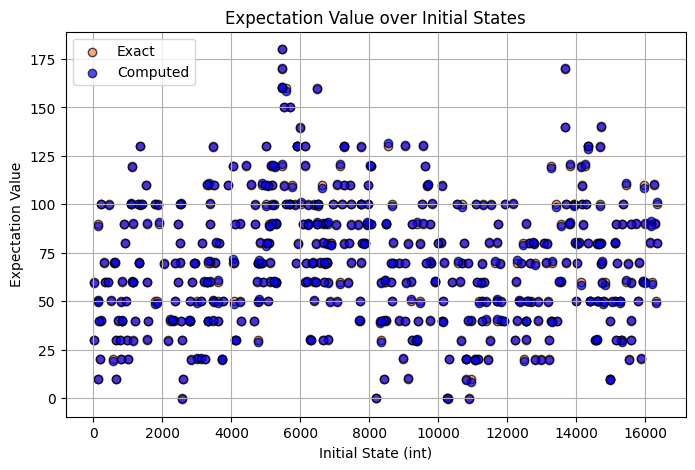

In [17]:
import matplotlib.pyplot as plt

def plot_scatter(x_values, y_values, y_values_2):
    """
    Plots a scatter plot with x_values on the x-axis and y_values on the y-axis.

    Args:
        x_values (list or array): Values for the x-axis.
        y_values (list or array): Values for the y-axis.
    """
    if len(x_values) != len(y_values):
        raise ValueError("Both input arrays must have the same length.")

    plt.figure(figsize=(8, 5))  # Set figure size
    plt.scatter(x_values, y_values, color='coral', alpha=0.7, edgecolors='black', label='Exact')
    plt.scatter(x_values, y_values_2, color='blue', alpha=0.7, edgecolors='black', label='Computed')

    plt.xlabel("Initial State (int)")
    plt.ylabel("Y Values")
    plt.ylabel("Expectation Value")
    plt.title("Expectation Value over Initial States")
    plt.grid(True)

    plt.legend()

    plt.show()

# plot the data we collected
plot_scatter(init_values, exact_energies, computed_energies)


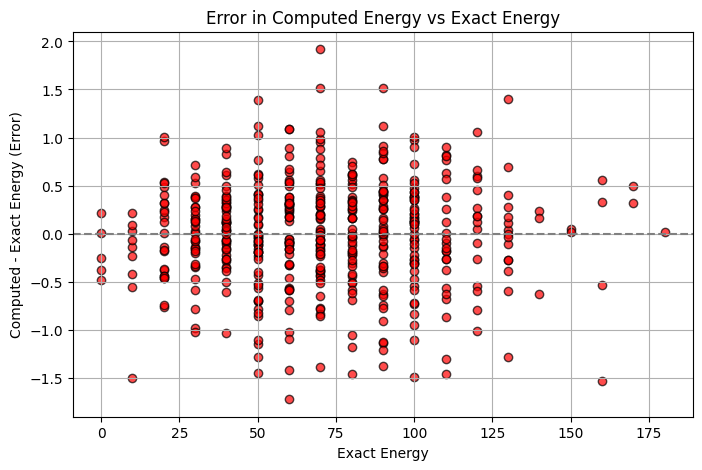

In [18]:
import matplotlib.pyplot as plt

def plot_error(exact_energies, computed_energies):
    """
    Plots the difference (computed - exact) against exact_energies.

    Args:
        exact_energies (list or array): Exact energy values (x-axis).
        computed_energies (list or array): Computed energy values.

    """
    if len(exact_energies) != len(computed_energies):
        raise ValueError("Arrays must have the same length.")

    # Compute the difference (error)
    errors = [computed - exact for computed, exact in zip(computed_energies, exact_energies)]

    # Create scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(exact_energies, errors, color='red', alpha=0.7, edgecolors='black')

    # Labels and title
    plt.xlabel("Exact Energy")
    plt.ylabel("Computed - Exact Energy (Error)")
    plt.title("Error in Computed Energy vs Exact Energy")
    plt.axhline(0, color='gray', linestyle='--')  # Add horizontal line at 0 for reference
    plt.grid(True)

    plt.show()

# Example usage
plot_error(exact_energies, computed_energies)



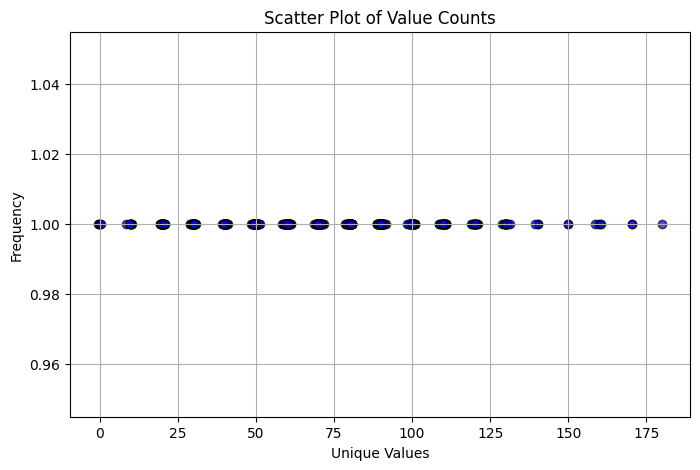

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_value_counts(x_values):
    """
    Plots a scatter plot where the x-axis represents unique values from x_values,
    and the y-axis represents their frequency (number of occurrences).

    Args:
        x_values (list or array): Values for the x-axis.
    """
    # Count occurrences of each unique value
    value_counts = Counter(x_values)

    # Extract unique values and their counts
    unique_x = list(value_counts.keys())
    counts = list(value_counts.values())

    # Create scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(unique_x, counts, color='blue', alpha=0.7, edgecolors='black')

    # Labels and title
    plt.xlabel("Unique Values")
    plt.ylabel("Frequency")
    plt.title("Scatter Plot of Value Counts")
    plt.grid(True)

    plt.show()

plot_value_counts(computed_energies)
